# Reconstruction Analysis
It is now important to understand how well our reconstruction worked. Finding a clear metric allow us to fine tune number of scans required as well the necessity of new steps that coudld improve robustness and accuracy.

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import binary_fill_holes

from src.io_utils import load_stl_as_array
from src.constants import gb_cmap
from src.physics_utils import center_volume, volume_reshape
from src.registrator import Registrator

example_camera = 0
plt.style.use('dark_background')

## 1. Volume Import
To do any type of analysis is important we have the original and reconstructed volume imported with the same resolution as an array. 

0.37133017


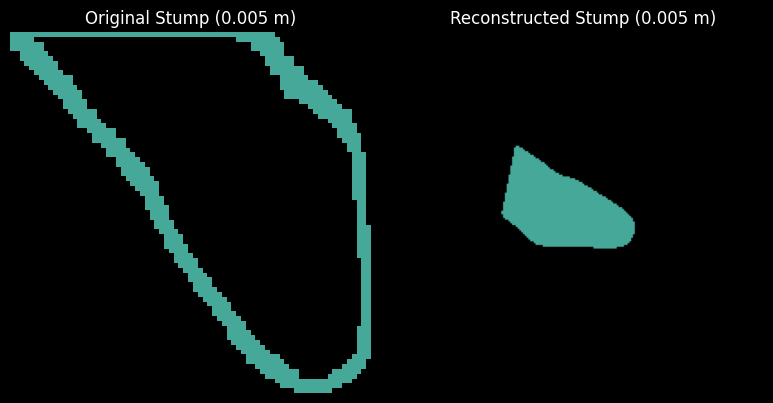

Original Stump Shape: (75, 75, 75), Reconstructed Stump Shape: (200, 200, 200)


In [46]:
original_stump, voxel_size = load_stl_as_array("../blender_simulator/objects/stump.stl", 0.005)
reconstructed_stump = pickle.load(open("reconstruction_mesh/30d_convex_hull_voxel0.005.pkl", "rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Whater-tight the original stump
original_stump[:, 0, :] = binary_fill_holes(original_stump[:, 0, :]).astype(np.uint8)

ax1.imshow(original_stump[original_stump.shape[0]//2, :, :], cmap=gb_cmap)
ax1.set_title(f'Original Stump ({voxel_size:.1} m)')
ax1.axis('off')

ax2.imshow(reconstructed_stump[100, :, :], cmap=gb_cmap)
ax2.set_title('Reconstructed Stump (0.005 m)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Original Stump Shape: {original_stump.shape}, Reconstructed Stump Shape: {reconstructed_stump.shape}")

Clearly we have some issues we need to make sure are fixed before we can do any comparisons. These include:
- Make sure that both have the **same voxel size**
- Make sure both are **filled** (whater-tight)
- Maker sure both are aligned

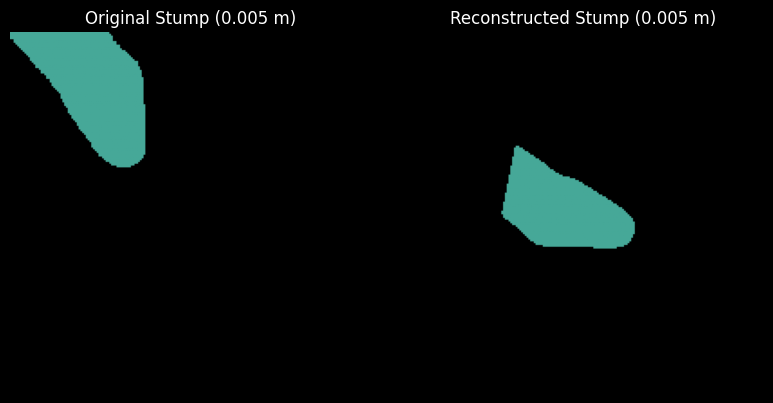

In [47]:
# RESHAPE
reshaped_original_stump = volume_reshape(original_stump, reconstructed_stump)

# FILLING
reshaped_original_stump = binary_fill_holes(reshaped_original_stump).astype(np.uint8)

# VISUALIZATION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(reshaped_original_stump[original_stump.shape[0]//2, :, :], cmap=gb_cmap)
ax1.set_title(f'Original Stump ({voxel_size:.1} m)')
ax1.axis('off')

ax2.imshow(reconstructed_stump[reconstructed_stump.shape[0]//2, :, :], cmap=gb_cmap)
ax2.set_title('Reconstructed Stump (0.005 m)')
ax2.axis('off')

plt.tight_layout()
plt.show()

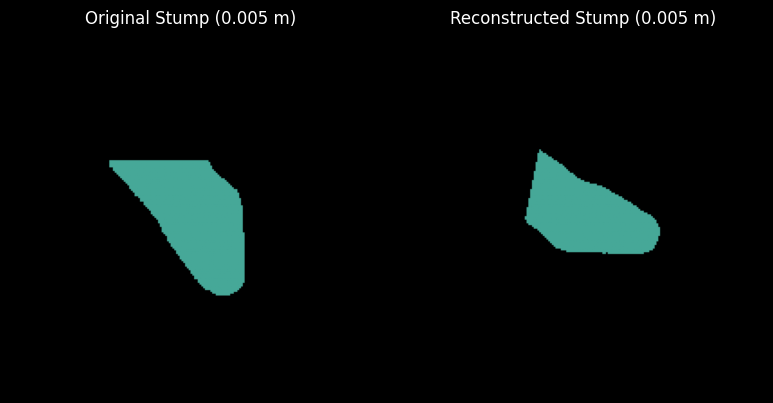

Number of voxels in original stump: 168109, Number of voxels in reconstructed stump: 62490


In [48]:
original_centered = center_volume(reshaped_original_stump)
reconstructed_centered = center_volume(reconstructed_stump)

# VISUALIZATION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(original_centered[original_centered.shape[0]//2, :, :], cmap=gb_cmap)
ax1.set_title(f'Original Stump ({voxel_size:.1} m)')
ax1.axis('off')

ax2.imshow(reconstructed_centered[reconstructed_centered.shape[0]//2, :, :], cmap=gb_cmap)
ax2.set_title('Reconstructed Stump (0.005 m)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of voxels in original stump: {np.sum(original_centered)}, Number of voxels in reconstructed stump: {np.sum(reconstructed_centered)}")

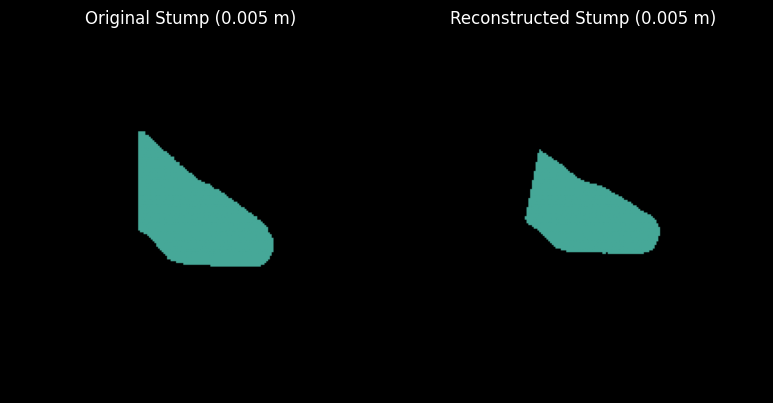

Number of voxels in original stump: 168109, Number of voxels in reconstructed stump: 62490


In [ ]:
# Rotate and flip original for better alignment
original_flipped = np.flip(original_centered, axis=1)
original_flipped = np.rot90(original_flipped, k=1, axes=(2, 1))

# VISUALIZATION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(original_flipped[original_flipped.shape[0]//2, :, :], cmap=gb_cmap)
ax1.set_title(f'Original Stump ({voxel_size:.1} m)')
ax1.axis('off')

ax2.imshow(reconstructed_centered[reconstructed_centered.shape[0]//2, :, :], cmap=gb_cmap)
ax2.set_title('Reconstructed Stump (0.005 m)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of voxels in original stump: {np.sum(original_centered)}, Number of voxels in reconstructed stump: {np.sum(reconstructed_centered)}")

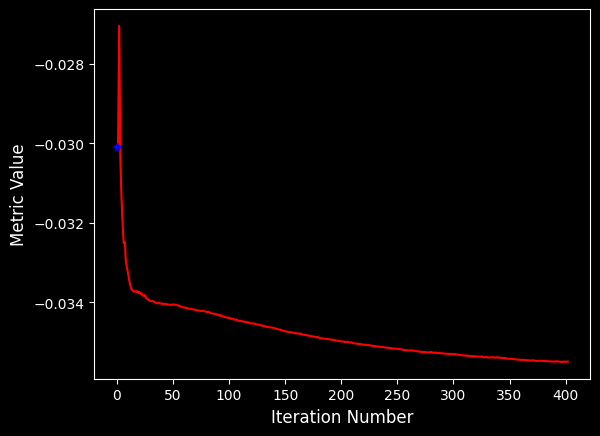

In [56]:
volume_registrator = Registrator(optimizer='GD', sampling_percentage=1, learning_rate=1e-10, convergenceMinimumValue=1e-10, convergenceWindowSize=10, maxIterations=1000)
aligned_original_stump, _ = volume_registrator.register(reconstructed_centered, original_flipped)

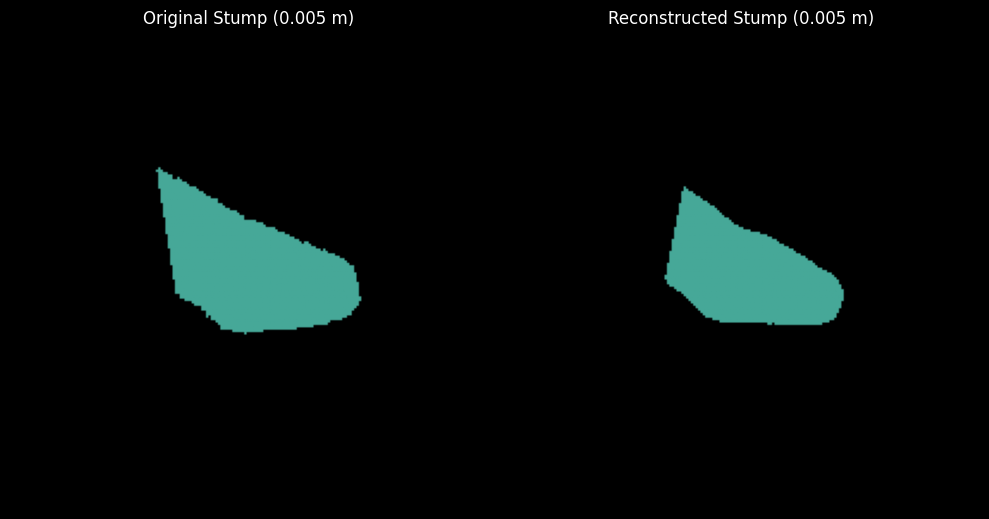

Number of voxels in aligned original stump: 168111.0, Number of voxels in reconstructed stump: 62490


In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ax1.imshow(aligned_original_stump[original_centered.shape[0]//2, :, :], cmap=gb_cmap)
ax1.set_title(f'Original Stump ({voxel_size:.1} m)')
ax1.axis('off')

ax2.imshow(reconstructed_centered[reconstructed_centered.shape[0]//2, :, :], cmap=gb_cmap)
ax2.set_title('Reconstructed Stump (0.005 m)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of voxels in aligned original stump: {np.sum(aligned_original_stump)}, Number of voxels in reconstructed stump: {np.sum(reconstructed_centered)}")

## 2. Volume Comparison
Let's see what is the volume difference between both

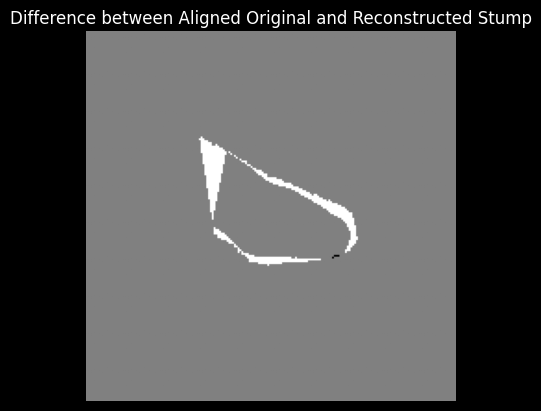

Difference in voxels: 62.89%


In [67]:
plt.figure()
plt.imshow(aligned_original_stump[aligned_original_stump.shape[0]//2, :, :] - reconstructed_centered[reconstructed_centered.shape[0]//2, :, :], cmap='gray', vmin=-1, vmax=1)
plt.title('Difference between Aligned Original and Reconstructed Stump')
plt.axis('off')
plt.show()

print(f"Difference in voxels: {(np.sum(np.abs(aligned_original_stump - reconstructed_centered)) / np.sum(aligned_original_stump) * 100):.2f}%")